In [1]:
import sys
sys.path.append('../_amigocloud')

In [2]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon

In [3]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [5]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [13]:
semana = 24

In [14]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_puntos = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS.shp'
gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)

In [15]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


<Axes: >

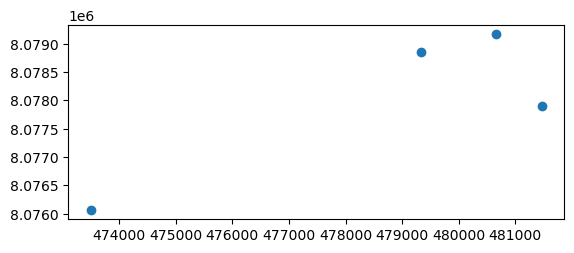

In [16]:
# filtrar la semna de interes
gdf_puntos_sem = gdf_puntos[gdf_puntos['semana'] == semana]
gdf_puntos_sem.plot()

In [17]:
# identifoca los lotes que se intersectan
gdf_lotes_selec = gpd.sjoin(gdf_siembras, gdf_puntos, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_selec.index)]
# copy
poligonos_intersect = poligonos_intersect.copy()
# agregar campo de semana_planificacion
poligonos_intersect['sem_plan'] = semana

In [19]:
poligonos_intersect

,sem_reg,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,geometry,sem_plan
491,19.0,1520,VILLA COPACABANA - CRONENBOLD,2641,CRONENBOLD AGUILERA ROBERTO,L32.2,0.967751,2024-03-25,SIEMBRA 2024,94,2024-03-25,"POLYGON ((473623.440 8076032.189, 473618.852 8...",24
494,19.0,63,SAN MARIANITO--CRONEMBOLD AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L30.1,8.381974,2024-03-13,SIEMBRA 2024,106,2024-03-13,"POLYGON ((480615.505 8078842.811, 480575.420 8...",24
497,19.0,63,SAN MARIANITO--CRONEMBOLD AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L1,12.759626,2024-03-17,SIEMBRA 2024,102,2024-03-17,"POLYGON ((479417.107 8079042.290, 479409.645 8...",24
504,19.0,63,SAN MARIANITO--CRONEMBOLD AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L51,9.680516,2024-03-22,SIEMBRA 2024,97,2024-03-22,"POLYGON ((481468.762 8078156.958, 481662.937 8...",24


In [18]:
# cargar el shp de planificacion existente
path_plan = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'
gdf_plan = gpd.read_file(path_plan)
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, poligonos_intersect], ignore_index=True)
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

C:\Users\bismarksr\AppData\Local\Temp\ipykernel_1148\249372087.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_pla_gral = pd.concat([gdf_plan, poligonos_intersect], ignore_index=True)


# CARGAR PLANIFICACION A AMIGOCLOUD

In [21]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [22]:
# repreyectar a WGS84
poligonos_intersect = poligonos_intersect.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
poligonos_intersect['geometry'] = poligonos_intersect['geometry'].apply(convertir_a_multipolygon)

In [23]:
poligonos_intersect

,sem_reg,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,geometry,sem_plan
491,19.0,1520,VILLA COPACABANA - CRONENBOLD,2641,CRONENBOLD AGUILERA ROBERTO,L32.2,0.967751,2024-03-25,SIEMBRA 2024,94,2024-03-25,"MULTIPOLYGON (((-63.24833 -17.40131, -63.24838...",24
494,19.0,63,SAN MARIANITO--CRONEMBOLD AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L30.1,8.381974,2024-03-13,SIEMBRA 2024,106,2024-03-13,"MULTIPOLYGON (((-63.18248 -17.37597, -63.18285...",24
497,19.0,63,SAN MARIANITO--CRONEMBOLD AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L1,12.759626,2024-03-17,SIEMBRA 2024,102,2024-03-17,"MULTIPOLYGON (((-63.19376 -17.37416, -63.19383...",24
504,19.0,63,SAN MARIANITO--CRONEMBOLD AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L51,9.680516,2024-03-22,SIEMBRA 2024,97,2024-03-22,"MULTIPOLYGON (((-63.17445 -17.38218, -63.17263...",24


In [24]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in poligonos_intersect.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (sem_reg, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, fecha_ini, origen, dias, sem_plan, geometry)
    VALUES ({row['sem_reg']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['fecha_ini']}', '{row['origen']}', '{row['dias']}', '{row['sem_plan']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR XLSX

In [120]:
path_plan_XLSX = f"G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S{semana}.xlsx"
path_plan_XLSX

'G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S23.xlsx'

In [123]:
poligonos_intersect.columns

Index(['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'geometry',
       'sem_plan'],
      dtype='object')

In [128]:
df_xlsx = poligonos_intersect[['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'sem_plan']]

In [129]:
df_xlsx.to_excel(path_plan_XLSX, index=False, engine='openpyxl')